In [236]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

### 1. Let's not be strangers!

For this problem we will work with the N-body code Rebound: https://rebound.readthedocs.io/en/latest/index.html. 
This has the advantage of having implementations in both C
and Python. Note the Python version works as a wrapper for the C code, so the functions
aren’t completely doubly implemented, e.g., digging into the details of the integrators code
requires opening the C code.
Before running any problems, let’s first get to know this code and how it works (happily,
this is relatively clean code and fairly straight-forward to parse).


a) Look through the documentation and poke around in the code. Let’s suppose we want to
integrate the orbits for a 3 body system. Draw a flow chart for how the code initializes and
evolves this interaction.

![orital simulation](Flowchart.png)

b) The code offers a variety of different choices of integrators. Make a table of the different
options, list their order of accuracy (if documented), what problems they are best suited for,
and note any tunable parameters.

| Intergrator | Order of accuracy | best suited for | tunable parameters |
| :-: | :-: | :-: | :-: |
| IAS15 | 15$^\textrm{th}$ | high accuracy orbit integration with non-conservative forces| `epsilon` = adjust adaptive timestepping, `min_dt` = minimum allowed timestep, `epsilon_global` = method of dertermining relative acceleration error|
| WHFast | 11$^\textrm{th}$ | for systems in which there is a dominant central object and perturbations to the Keplerian orbits are small|`unsigned int corrector` = turn on/off diferent first sympletic correctors, `unsigned int corrector2` =  turns on/off second symplectic correctors, `unsigned int kernel` = determines the kernel of the intergrator, `unsigned int coordinate`= set coordinate system  |
| Gragg-Bulirsch-Stoer (BS) | |  integrate arbitrary ODEs, for short integrations where only medium accuracy is required|`ri_bs.eps_rel`=sets relative tolerance, `ri_bs.eps_abs`= sets absolute tolerance, `min_dt`, `max_dt` = minimum and maximum timestep |
| Mercurius | 7$^\textrm{th}$| planet-planetary collisions, test particles, additional forces | `L`= function pointer to the force switching function, `hillfac`= multiplicative for the Hill radius of particles to determine critical switchover radii, `recalculate_coordinates_this_timestep`=recalculate heliocentric coordinates from the particle structure at the beginning of the next timestep, `recalculate_dcrit_this_timestep`=  recalculate the critical switchover distances dcrit at the beginning of the next timestep, `safe_mode`= If this flag is set to 1 (the default), the integrator will recalculate heliocentric coordinates and synchronize after every timestep to avoid problems with outputs or particle modifications between timesteps.|
| SABA | default 10$^\textrm{th}$ | perturbed Hamiltonian systems, planetary N-body problems|`type`=specifies which SABA integrator type, `safe_mode`=same as in WHFast, `keep_unsynchronized`| 
| JANUS | default 6$^\textrm{th}$| broad range, exactly time-reversible|`scale_pos`=scale of problem Positions get divided by this number before the conversion to an integer, `scale_vel`= Velocities get divided by this number before the conversion to an integer, `order`=order of the scheme|
| Embedded Operator Splitting Method (EOS) | 2$^\textrm{nd}$ to 8$^\textrm{th}$ order user defined via `phi0` and `phi1`|Plantary motion | `n`=number of sub-timesteps, `phi0`=outer operator splitting scheme, `phi1`= inner operator splitting scheme|
| Leapfrog | 2$^\textrm{nd}$ | non-rotating coordinate systems | --- |
| Symplectic Epicycle Integrator (SEI) | 2$^\textrm{nd}$ | epicyclic motion with no perturbing forces |`OMEGA` = epicyclic/orbital frequency, `OMEGAZ`=epicyclic frequency in vertical direction |


c) Look at the leapfrog and symplectic epicyclic integrator code (see the repository src
“source” directory). Make a flow chart for how these functions work. For production research
you would want to read the method papers for each of the solvers to better understand their
implementations, strengths and weaknesses. Here, this is not necessary unless you want to
dig deeper into how the algorithms work.

![leap frog and SEI](leapfrogSEI.png)

### 2. Hello Comets

a) You may recall seeing articles about the ESA Rosetta mission that visited and then sent
a probe to land on a comet. This was eponymously named 67P/Churyumov–Gerasimenko
comet (see https://en.wikipedia.org/wiki/67P/ChuryumovGerasimenko). There is an
example problem based on this comet, which we will use to get familiar with Rebound.
Set up and run the 67P/C-G example problem following the documentation (see Examples
→Planetary systems →Just getting started →The comet 67P/Churyumov-Gerasimenko).
Only include the Sun, Saturn and Jupiter for now. Include a plot of the 67P/C-G comet
and two planet orbits evolved over 70 years in your solution set.

In [216]:
def simulate(dt, total_time=70, Noutputs = 1000, integrator='ias15', planets=["Jupiter", "Saturn"], 
             plot_orbit=True, plot_distance=False, print_orbit=False):

    
    sim = rebound.Simulation()
    sim.add("Sun");
    names = ['Sun']
    for planet in planets:
        sim.add(planet);
        names.append(planet)
        
    sim.add("Churyumov-Gerasimenko", m=5.03e-18)
    names.append("Churyumov-Gerasimenko")
    
    Nobjects = len(planets)+2
    
    if print_orbit:
        for orbit in sim.calculate_orbits():
            print(orbit)

    sim.dt = dt
    Noutputs = Noutputs
    year = 2.*np.pi # One year in units where G=1
    times = np.linspace(0.,total_time*year, Noutputs)
    x = np.zeros((Nobjects,Noutputs))
    y = np.zeros((Nobjects,Noutputs))
    z = np.zeros((Nobjects,Noutputs))

    sim.integrator = integrator
    sim.move_to_com()        # We always move to the center of momentum frame before an integration
    ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

    for i,time in enumerate(times):
        sim.integrate(time)
        for j in range(Nobjects):
            x[j][i] = ps[j].x   # This stores the data which allows us to plot it later
            y[j][i] = ps[j].y
            z[j][i] = ps[j].z

    #Jupitor is index1, comet is last object
    distance = np.sqrt(np.square(x[(Nobjects)-1]-x[1])+np.square(y[(Nobjects)-1]-y[1])+
                       np.square(z[(Nobjects)-1]-z[1]))    
    if plot_orbit:
        if plot_distance:
            ### Plot both
            fig = plt.figure(figsize=(15,5))
            spec = fig.add_gridspec(1, 3, wspace=0.0)
            ax = fig.add_subplot(spec[0,0])
            ax2 = fig.add_subplot(spec[0,1:])
            for j in range(Nobjects):
                if names[j] == 'Churyumov-Gerasimenko':
                    ax.plot(x[j], y[j], label = '{}'.format(names[j]));
                else:
                    ax.plot(x[j], y[j], color='k', alpha = 0.7, lw = 0.5);

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('Orbit over last 70 years ({} integration, dt={})'.format(integrator, dt))
            ax2.set_xlabel("time [yrs]")
            ax2.set_ylabel("distance [AU]")
            ax2.set_title("distance between {} and {}".format(names[(Nobjects)-1], names[1]))
       
            ax2.plot(times/year, distance);
            ax2.yaxis.set_label_position("right")
            ax2.yaxis.tick_right()
            ax.legend()
            
        else:    #Just plot orbits
            fig = plt.figure(figsize=(8,8))        
            ax = plt.subplot(111)

            for j in range(Nobjects):
                ax.plot(x[j], y[j], label = '{}'.format(names[j]));
            ax.set_title('Orbit over last 70 years ({} integration, dt={})'.format(integrator, dt))
            ax.legend()


    closeencountertime = times[np.argmin(distance)]/year
    print("Minimum distance (%f AU) occured at time: %f years." % (np.min(distance),closeencountertime))
    
    return x, y, z, dt, integrator, times, distance

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')
Minimum distance (0.060779 AU) occured at time: -63.063063 years.


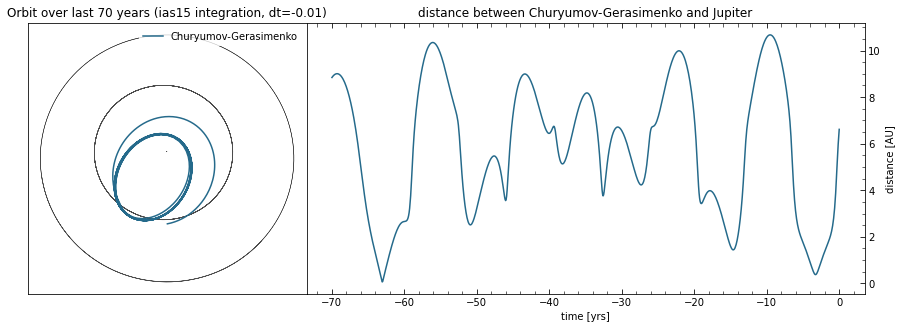

In [217]:
x, y, z, dt, integrator, t, d = simulate(dt=-0.01, total_time=-70, plot_distance=True)

b) Experiment with the timestep and integrator choice (e.g., IAS15 vs WHFast). How does
the result change with different integrators? What integrator(s) do you think work best for
this problem? How does the result change as a function of the timestep? E.g., you can evaluate this by looking at energy conservation and the change in orbits. (Note IAS15 has
adaptive timestepping so you have to set the minimum timestep.)

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')
Minimum distance (0.060779 AU) occured at time: -63.063063 years.
Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')
Minimum distance (0.060779 AU) occured at time: -63.063063 years.
Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupite

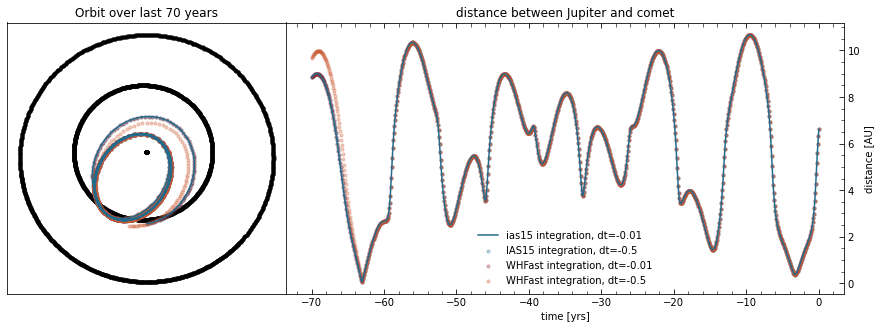

In [226]:
#Changing dt with the same integration scheme as a)
x1, y1, z1, dt1, int1, t1, d1 = simulate(dt=-0.5, total_time=-70, integrator='IAS15', plot_orbit=False)

#Changing integration scheme with the same dt as a)
x2, y2, z2, dt2, int2, t2, d2 = simulate(dt=-0.01, total_time=-70, integrator='WHFast', plot_orbit=False)

#Changing both integration scheme and dt 
x3, y3, z3, dt3, int3, t3, d3 = simulate(dt=-0.5, total_time=-70, integrator='WHFast', plot_orbit=False)

year = 2.*np.pi
fig = plt.figure(figsize=(15,5))
spec = fig.add_gridspec(1, 3, wspace=0.0)
ax = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1:])
for j in range(4):
    if j==3:
        ax.plot(x[j], y[j], label = '{} integration, dt={}'.format(integrator, dt))
        ax.scatter(x1[j], y1[j], alpha=0.3, s=10, label = '{} integration, dt={}'.format(int1, dt1))
        ax.scatter(x2[j], y2[j], alpha=0.3, s=10, label = '{} integration, dt={}'.format(int2, dt2))
        ax.scatter(x3[j], y3[j], alpha=0.3, s=10, label = '{} integration, dt={}'.format(int3, dt3))
    else:
        ax.plot(x[j], y[j], color='k', alpha = 0.3, lw = 0.5);
        ax.scatter(x1[j], y1[j], color='k', alpha=0.3, s=10, label = '{} integration, dt={}'.format(int1, dt1))
        ax.scatter(x2[j], y2[j], color='k', alpha=0.3, s=10, label = '{} integration, dt={}'.format(int2, dt2))
        ax.scatter(x3[j], y3[j], color='k', alpha=0.3, s=10, label = '{} integration, dt={}'.format(int3, dt3))

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Orbit over last 70 years')
ax2.set_xlabel("time [yrs]")
ax2.set_ylabel("distance [AU]")
ax2.set_title("distance between Jupiter and comet")

ax2.plot(t/year, d, label = '{} integration, dt={}'.format(integrator, dt));
ax2.scatter(t1/year, d1, alpha=0.3, s=10,label = '{} integration, dt={}'.format(int1, dt1))
ax2.scatter(t2/year, d2, alpha=0.3, s=10,label = '{} integration, dt={}'.format(int2, dt2))
ax2.scatter(t3/year, d3, alpha=0.3, s=10, label = '{} integration, dt={}'.format(int3, dt3))
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.legend()

The orbit changes with the integrators as we integrate back in time past the closest encounter time. IAS15 is more accurate in this case. While if we set small dt, both integrators are able to perform accurately, if we increase dt, IAS15 performs similarly, but we see the deviation from IAS15 with WHFast. This is because WHFast assumes that the gravitational force on a planet from the central body dominates that from all other particles, however, a close approach (such as that occuring ~63 years ago violates this approximation, and that's why we see the deviation in orbit in earlier times. This encounter makes WHFast less ideal for this problem, but a higher order integrator such as IAS15 does not have problems with this encounter. 

c) How does the orbit of 67PC-G change when you add the rest of the Solar System planets?
Which is the larger source of error – the parameter choices such as the integrator and/or
timestep or missing bodies?

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Mars'... 
Found: Mars Barycenter (4) (chosen from query 'Mars')
Searching NASA Horizons for 'Venus'... 
Found: Venus Barycenter (299) (chosen from query 'Venus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Earth'... 
Found: Earth-Moon Barycenter (3) (chosen from query 'Earth')
Searching NASA Horizons for 'Mercury'... 
Found: Mercury Barycenter (199) (chosen from query 'Mercury')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')
Minimum distan

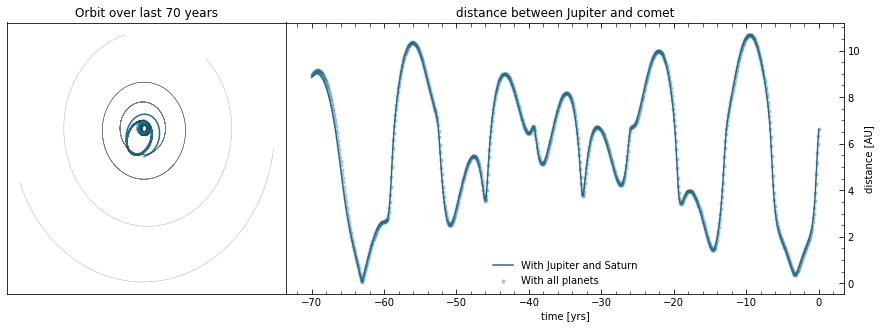

In [229]:
planets = ['Jupiter', 'Saturn','Mars', 'Venus', 'Neptune', 'Uranus', 'Earth', 'Mercury']
xp, yp, zp, dtp, intp, tp, dp = simulate(dt=-0.01, total_time=-70, plot_orbit=False, 
         planets=planets)

year = 2.*np.pi
fig = plt.figure(figsize=(15,5))
spec = fig.add_gridspec(1, 3, wspace=0.0)
ax = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1:])
for j in range(4):
    if j==3:
        ax.plot(x[j], y[j], label = '{} integration, dt={}'.format(integrator, dt))
    else:
        ax.plot(x[j], y[j], color='k', alpha = 0.3, lw = 0.5);
        #ax.scatter(xp[j], yp[j], color='k', alpha=0.3, s=10)
        
for j in range(len(planets)):
    if j==len(planets)-1:
        ax.scatter(xp[j], yp[j], alpha=0.3, s=10)

    else:
        ax.plot(xp[j], yp[j], color='k', alpha = 0.3, lw = 0.5);

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Orbit over last 70 years')
ax2.set_xlabel("time [yrs]")
ax2.set_ylabel("distance [AU]")
ax2.set_title("distance between Jupiter and comet")

ax2.plot(t/year, d, label = 'With Jupiter and Saturn');
ax2.scatter(tp/year, dp, alpha=0.3, s=10,label = 'With all planets')

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.legend()

The orbit of the comet does not change significantly as we add in all solar system planets. The largest source of error is the integrator and timestep. I would say the most important thing in these problems is choosing the best integrator for the problem in order to avoid the behavior we see with WHFast as we increase the timestep. With IAS15, we can increase the timestep while maintaining accuracy since it is a higher order integrator that is able to handle the close approach of the comet and jupiter better.

## 3. Finding Planet X (actually Planet Nine)
There is a long history of speculation that another undiscovered planet might exist outside
our Solar system. Originally this planet was known as “Planet X.” A more recent 2016 study
has hypothesized anew about the presence of a large planet beyond the Kuiper belt (now
called “Planet nine”). You can read through a brief summary of the proposed planet here:
https://en.wikipedia.org/wiki/Planet_Nine.

Set up a Solar System with all the planets and Pluto. Suppose Planet Nine has a semi-major
axis of 460 au and eccentricity of 0.4. How massive would it need to be to perturb Pluto’s
orbit by 10% after 10 years of evolution? Given your answer, why do you think we haven’t
found any Planet Nine yet?

In [234]:
def simulateP9(dt=-0.01, total_time=10, integrator='ias15'):
    """
    Runs two rebound.Simulation processes for our solar system, with and without hypothetical planet9
    runs simulation over mass steps to find the minimum mass required for planet9 to perturb
    pluto's orbit by 10% over the course of 10 years
    
    Parameters
    ----------
    dt : array 
        timestep
    total_time : array 
        unit years, time to run simulation
    integrator : array 
        default 'ias15', integration scheme

    Returns
    ----------
    None
    """
    sim = rebound.Simulation()
    simp9 = rebound.Simulation()
    
    sim.add("Sun")
    simp9.add("Sun")
    planets=['Jupiter', 'Saturn','Mars', 'Venus', 'Neptune', 'Uranus', 'Earth', 'Mercury', 'pluto']
    for planet in planets:
        sim.add(planet)
        simp9.add(planet)
     

    Nobjects = len(planets)

    sim.dt = dt

    Noutputs = 10000
    year = 2.*np.pi # One year in units where G=1
    times = np.linspace(0.,total_time*year, Noutputs)
    x = np.zeros((Nobjects,Noutputs))
    y = np.zeros((Nobjects,Noutputs))
    z = np.zeros((Nobjects,Noutputs))

    sim.integrator = integrator # IAS15 is the default integrator, so we actually don't need this line
    sim.move_to_com()        # We always move to the center of momentum frame before an integration
    ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

    for i,time in enumerate(times):
        sim.integrate(time)
        for j in range(Nobjects):
            x[j][i] = ps[j].x   # This stores the data which allows us to plot it later
            y[j][i] = ps[j].y
            z[j][i] = ps[j].z
    
    
    ### Add second simulation with planet 9
    logmass = -4
    perturbation = 0
    
    while perturbation < 0.1:
        
        simp9.add(m=10**logmass, a=460, e=0.4)

        simp9.integrator = integrator # IAS15 is the default integrator, so we actually don't need this line
        simp9.move_to_com()        # We always move to the center of momentum frame before an integration
        psp9 = simp9.particles       # ps is now an array of pointers and will change as the simulation runs

        simp9.dt = dt

        Noutputs = 10000
        year = 2.*np.pi # One year in units where G=1
        times = np.linspace(0.,total_time*year, Noutputs)
        xp9 = np.zeros((Nobjects+1,Noutputs))
        yp9 = np.zeros((Nobjects+1,Noutputs))
        zp9 = np.zeros((Nobjects+1,Noutputs))

        for i,time in enumerate(times):
            simp9.integrate(time)
            for j in range(Nobjects+1):
                xp9[j][i] = psp9[j].x   
                yp9[j][i] = psp9[j].y
                zp9[j][i] = psp9[j].z
        
        #Find the maximum difference in pluto's orbit between the simulations----------------------------
        # in the first simulation pluto is the last object: indexed by -1
        # in the planet9 simulation pluto is the second to last object: indexed by -2
        
        #perturbation is the maximum of the fractional difference 
        #i.e. maximum of : the difference between the two orbits/orbit without planet 9
        perturbation = np.max(np.sqrt((x[-1]-xp9[-2])**2+(y[-1]-yp9[-2])**2+(z[-1]-zp9[-2])**2)/
                              np.sqrt((x[-1])**2+(y[-1])**2+(z[-1])**2))
        
        logmass =logmass+0.1
        
    print('The mass for which planet9 needs to be to perturb plutos orbit by 10% is: 1e{}'.format(logmass))
    

In [235]:
simulateP9()

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Mars'... 
Found: Mars Barycenter (4) (chosen from query 'Mars')
Searching NASA Horizons for 'Mars'... 
Found: Mars Barycenter (4) (chosen from query 'Mars')
Searching NASA Horizons for 'Venus'... 
Found: Venus Barycenter (299) (chosen from query 'Venus')
Searching NASA Horizons for 'Venus'... 
Found: Venus Barycenter (299) (chosen from query 'Venus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')
Sear

The mass for which planet9 needs to be to perturb plutos orbit by 10% is: 1e-3.8$M_\odot$, this is about 100 times more massive than Jupiter. This is beyond planetary mass. Therefore it is much more likely that if planet 9 exists, it is far less massive and thus would perturb pluto's orbit by a much smaller amount than 10% over 10 years. Meaning that in order to observe the effect of Planet 9 on pluto, we would have to observe plutos orbit to much higher precision and over a longer course of time, which is both difficult to achieve.